# Using the picasso analytical gas model

This notebook shows how one can use the `picasso.polytrop` and `picasso.nonthermal` modules to compute gas properties from a gravitational potential distribution.
For a full documentation of the functions available in both modules, see {doc}`../api/polytrop` and {doc}`../api/nonthermal`.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM

from picasso import polytrop, nonthermal
from picasso.test_data import halos, profs

import seaborn as sns
sns.set_style("darkgrid")
sns.set_theme("notebook")

benchmark = True

## The analytical gas model

The polytropic gas model can be written as (see Kéruzoré+24):

$$
\rho(\phi, \, r) = \rho_0 \theta^{\Gamma(r) / (\Gamma(r) - 1)}(\phi), \\[10pt]
P(\phi, \, r) = P_0 \theta^{1 / (\Gamma(r) - 1)}(\phi),
$$
where $\phi$ is the halo's gravitational potential, and
$$
\theta(\phi) = 1 - \theta_0 (\phi - \phi_0),
$$

The gas polytropic index, $\Gamma$, is allowed to vary with radius as:

$$
\Gamma(r) = 
\begin{cases}
\begin{aligned}
    & \; 1 + (\Gamma_0 - 1) \frac{1}{1 + e^{-x}} & c_\Gamma > 0; \\
    & \; \Gamma_0 & c_\Gamma = 0; \\
    & \; \Gamma_0 + (\Gamma_0 - 1) \left(1 - \frac{1}{1 + e^{x}}\right) & c_\Gamma < 0, \\
\end{aligned}
\end{cases}
$$

with $x \equiv r / (c_\gamma R_{500c})$.

This model has five parameters: $(\rho_0, P_0)$ are the central value of gas density and pressure, $\Gamma_0$ is the asymptotic value of the polytropic index as $r \rightarrow \infty$, $c_\gamma$ is the polytropic concentration ($c_\gamma = 0$ implies $\Gamma(r) = \Gamma_0$), and $\theta_0$ is a shape parameter.

We further write the fraction of non-thermal pressure as a power-law of radius, plus a constant plateau:

$$
f_{\rm nt}(r) = A_{\rm nt} + (B_{\rm nt} - A_{\rm nt}) \left(\frac{r}{2R_{500c}}\right)^{C_{\rm nt}}
$$

This adds three parameters to our gas model:  $A_{\rm nt}$ is the central value of non-thermal pressure fraction, $B_{\rm nt}$ is the non-thermal pressure fraction at $r=2R_{500c}$, and $C_{\rm nt}$ is the power law evolution with radius.

## Halo potential and gas model parameters

Making predictions of gas properties using this model requires two ingredients: a potential distribution, and a vector containing values for the eight parameters of the gas model, $\vartheta_{\rm gas}$.
The `picasso` model is based on using a neural network to predict the latter (see {myst_nb:doc}`make_predictions`); here, we are interested in using the gas model independently, assuming we independently obtained a prediction of the vector parameter.

We will use simple NFW halos to make predictions.
We'll use some pre-stored data (containing mass and concentration values for four halos from the simulations presented in Kéruzoré+24) and compute their potential profiles:

In [2]:
phi, r_R500c = profs["phi"], profs["r_R500"]

For simplicity, we will use fixed values for the parameter vector $\vartheta_{\rm gas}$:

In [3]:
# rho_0, P_0, Gamma_0, c_gamma, theta_0, A_nt, B_nt, C_nt
theta_gas = jnp.array([3.22e3, 1.91e2, 1.134, 0.0, 3.594e-7, 1.18e-2, 2.11e-1, 1.647])

## Polytropic model: density and total pressure

First, focusing on one halo, we can use `polytrop.rho_P_g` to compute density and total pressure:

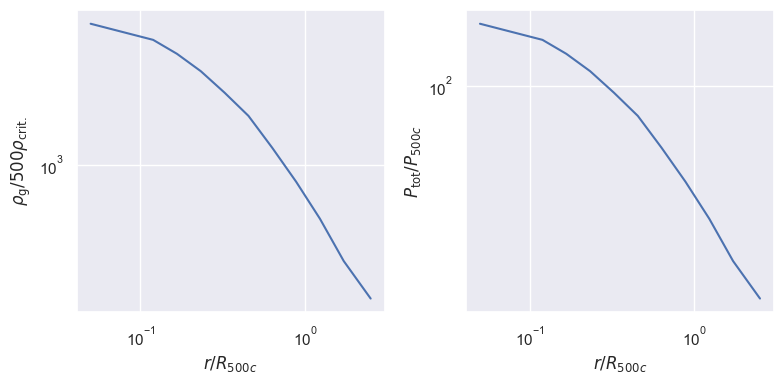

In [4]:
rho_g, P_tot = polytrop.rho_P_g(phi[0], r_R500c[0], *theta_gas[:5])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, q in zip(axs, [rho_g, P_tot]):
    ax.loglog(r_R500c[0], q)
    ax.set_xlabel("$r / R_{500c}$")
axs[0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit.}$")
axs[1].set_ylabel("$P_{\\rm tot} / P_{500c}$")
fig.tight_layout()

The function can easily be compiled just-in-time:

In [5]:
rho_P_g = jax.jit(polytrop.rho_P_g)
rho_g, P_tot = rho_P_g(phi[0], r_R500c[0], *theta_gas[:5])

if benchmark:
    print("Not jitted:", end=" ")
    %timeit _ = polytrop.rho_P_g(phi[0], r_R500c[0], *theta_gas[:5])
    print("jitted:", end=" ")
    %timeit _ = rho_P_g(phi[0], r_R500c[0], *theta_gas[:5])

Not jitted: 412 µs ± 7.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jitted: 114 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Non-thermal pressure fraction and thermal pressure

Similarly, the non-thermal pressure fraction can be computed using `nonthermal.f_nt_generic`, and be used to derive the thermal pressure:

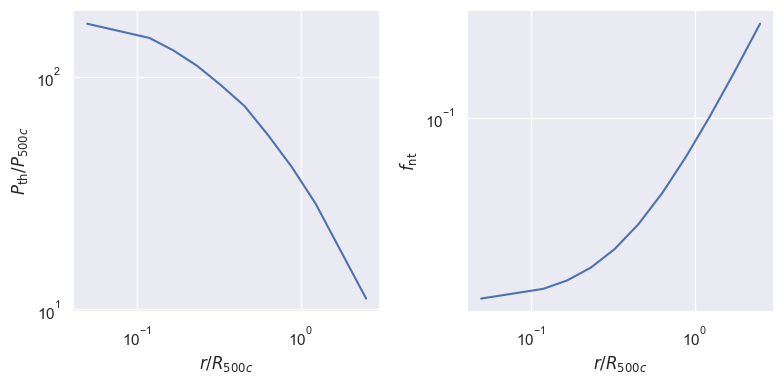

In [6]:
f_nt = nonthermal.f_nt_generic(r_R500c[0] / 2, *theta_gas[5:])
P_th = P_tot * (1 - f_nt)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, q in zip(axs, [P_th, f_nt]):
    ax.loglog(r_R500c[0], q)
    ax.set_xlabel("$r / R_{500c}$")
axs[0].set_ylabel("$P_{\\rm th} / P_{500c}$")
axs[1].set_ylabel("$f_{\\rm nt}$")
fig.tight_layout()

These can also be compiled:

In [7]:
@jax.jit
def f_nt_and_P_th(*args):
    f_nt = nonthermal.f_nt_generic(*args)
    return f_nt, P_tot * (1 - f_nt)

_ = f_nt_and_P_th(r_R500c[0] / 2, *theta_gas[5:])

## Batch predictions

The `picasso.polytrop` and `picasso.nonthermal` modules can also be used to make predictions for several halos at a time:

In [8]:
theta_gas = jnp.array([
    [6.8168e+02, 4.2554e+01, 1.1553e+00, 0.0000e+00, 9.0783e-07, 4.2568e-02, 2.6434e-01, 8.6513e-01],
    [1.1593e+03, 6.6720e+01, 1.1435e+00, 0.0000e+00, 5.1063e-07, 3.7982e-02, 2.7196e-01, 1.0898e+00],
    [1.1806e+03, 6.6686e+01, 1.1394e+00, 0.0000e+00, 3.4640e-07, 4.1790e-02, 3.0468e-01, 1.0849e+00],
    [6.2562e+02, 3.4515e+01, 1.1449e+00, 0.0000e+00, 2.8243e-07, 4.9366e-02, 3.3784e-01, 8.4570e-01],
    [8.4713e+02, 4.7153e+01, 1.1409e+00, 0.0000e+00, 1.7668e-07, 4.3313e-02, 3.4503e-01, 9.4095e-01],
    [9.0735e+02, 5.1616e+01, 1.1423e+00, 0.0000e+00, 1.2721e-07, 4.0001e-02, 3.5159e-01, 9.7828e-01],
    [1.8332e+03, 1.0815e+02, 1.1419e+00, 0.0000e+00, 7.6836e-08, 2.4986e-02, 3.2474e-01, 1.3087e+00]
])

We have to be a bit smart about array shapes here (or, alternatively, one may want to use `jax.vmap`):

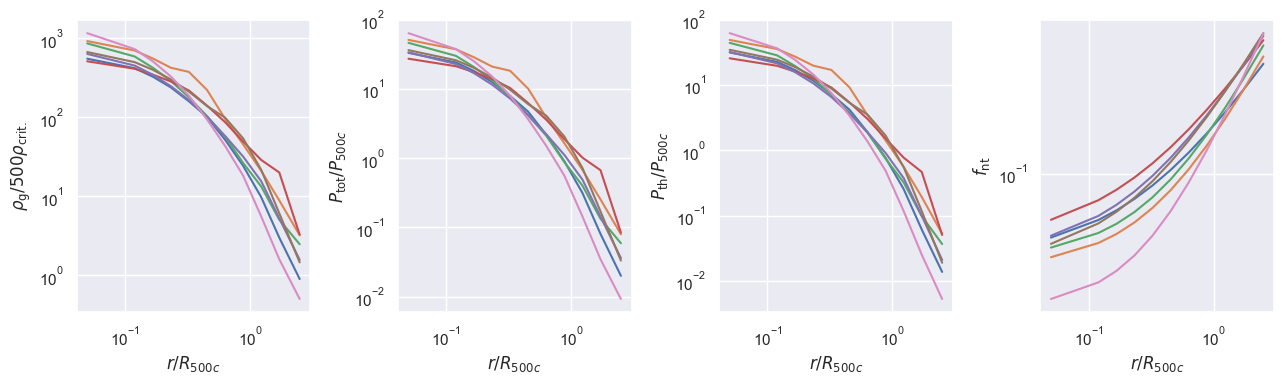

In [10]:
def thermodynamics(phi, theta_gas, r_pol, r_fnt):
    rho_g, P_tot = polytrop.rho_P_g(
        phi, r_pol,
        theta_gas[..., 0, None],
        theta_gas[..., 1, None],
        theta_gas[..., 2, None],
        theta_gas[..., 3, None],
        theta_gas[..., 4, None],
    )
    f_nt = nonthermal.f_nt_generic(
        r_fnt,
        theta_gas[..., 5, None],
        theta_gas[..., 6, None],
        theta_gas[..., 7, None],
    )
    return rho_g, P_tot, P_tot * (1 - f_nt), f_nt

rho_g, P_tot, P_th, f_nt = thermodynamics(phi, theta_gas, r_R500c, r_R500c / 2)

fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for ax, q in zip(axs, [rho_g, P_tot, P_th, f_nt]):
    ax.loglog(r_R500c.T, q.T)
    ax.set_xlabel("$r / R_{500c}$")

axs[0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit.}$")
axs[1].set_ylabel("$P_{\\rm tot} / P_{500c}$")
axs[2].set_ylabel("$P_{\\rm th} / P_{500c}$")
axs[3].set_ylabel("$f_{\\rm nt}$")
fig.tight_layout()

Again, these functions can be compiled:

In [11]:
if benchmark:
    print("Not jitted:", end=" ")
    %timeit _ = thermodynamics(phi, theta_gas, r_R500c, r_R500c / 2)

    thermodynamics = jax.jit(thermodynamics)
    print("jitted:", end=" ")
    %timeit _ = thermodynamics(phi, theta_gas, r_R500c, r_R500c / 2)

Not jitted: 1.26 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jitted: 17.6 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
